# A mathemactical model for calculating profiles of cosmogenic nuclides concentration vs. depth

In this notebook we show the equations of the model that we'll use to calculate profiles of nuclides concentration vs. depth. A more detailled description of the theoretical background behind this model can be found in, e.g., [Braucher et al., 2003][1], [Siame et al., 2004][2] and [Rixhon et al., 2011][3]. 

The contribution of a specific particule type $p$ to the concentration of a particular nuclide can be written as:

$$P_p,\Lambda_p \rightarrow c_p(z,\epsilon,t,\rho) = \frac{P_p} {\frac{\rho \, \epsilon}{\Lambda_p} + \lambda} \cdot \exp\left[{-\frac{\rho \, z}{\Lambda_p}}\right] \left[1 - \exp\left\{-t \left(\frac{\rho \, \epsilon}{\Lambda_p} + \lambda \right)\right\}\right]$$

where $z$ (cm) is the depth below the surface, $\epsilon$ (cm yr$^{-1}$) is the erosion rate, $t$ (yr) is the exposure time, $\rho$ (g cm$^{-3}$) is the soil density, $\lambda$ (yr$^{-1}$) is the radioactive decay constant, $P_p$ (atom g$^{-1}$yr$^{-1}$) is the production rate of the nuclide at the surface due to the particule, and $\Lambda_p$ (g cm$^{-2}$) is the effective apparent attenuation length for that particule type.

The nuclide concentration is the sum of individual contributions plus inheritance (i.e., a function of the concentration of the nuclide at the initiation of the exposure scenario). For example, for $^{10}Be$, we have:


$$
\begin{align}
C^{\mathrm{10Be}}(z,\epsilon,t,\rho) = & P_n,\Lambda_n & \rightarrow & c_n(z,\epsilon,t,\rho) & + \\
& P_{\mu \mathrm{Slow}},\Lambda_{\mu \mathrm{Slow}} & \rightarrow & c_{\mu \mathrm{Slow}}(z,\epsilon,t,\rho) & + \\
& P_{\mu \mathrm{Fast}},\Lambda_{\mu \mathrm{Fast}} & \rightarrow & c_{\mu \mathrm{Fast}}(z,\epsilon,t,\rho) & + \\
& C^{\mathrm{10Be}}_{t0} \cdot e^{-\lambda t} & &
\end{align}
$$

where $C^{\mathrm{10Be}}_{t0}$ (atoms g$^{-1}$) is the $^{10}Be$ concentration at the initiation of the exposure scenario, and $c_n(z,\epsilon,t,\rho)$, $c_{\mu \mathrm{Slow}}(z,\epsilon,t,\rho)$ and $c_{\mu \mathrm{Fast}}(z,\epsilon,t,\rho)$ are the contributions of neutrons, slow muons and fast muons, respectively. Inheritance is assumed to be equal for all sediment particles taken along the depth profile, which is a simplistic assumption though reasonable if the depth profile formed during a single geomorphic event that involved particle mixing. 

Here below is a Python/Numpy vectorized implementation of this model. The code is saved in the file `models.py` so that is can be re-used in other notebooks. 

[1]: http://dx.doi.org/10.1016/S0012-821X(03)00205-X
[2]: http://dx.doi.org/10.1016/S0012-821X(04)00061-5
[3]: http://dx.doi.org/10.1016/j.quageo.2010.11.001

In [1]:
%%writefile models.py

"""
Models for calculating profiles of cosmogenic nuclide
concentration vs. depth

Author: B. Bovy
"""

import math

import numpy as np


def _particle_contrib(depth, erosion, exposure, density,
                      nuclide, particle):
    """
    Contribution of a specific particle type
    to the nuclide concentration.
    """
    return (
        particle['prod_rate'] / ((density * erosion / 
                                  particle['damping_depth']) 
                                 + nuclide['rdecay']) *
        np.exp(-1. * density * depth / particle['damping_depth']) *
        (1. - np.exp(-1. * exposure * ((erosion * density / 
                                       particle['damping_depth'])
                                       + nuclide['rdecay'])))
    )


def C_nuclide(depth, erosion, exposure, density,
              inheritance, nuclide, particles):
    """
    Calculate the concentration(s) of a nuclide
    at given depth(s) (generic function).
    
    Parameters
    ----------
    depth : float or array_like
        depth(s) below the surface [cm]
    erosion : float or array_like
        erosion rate(s) [cm yr-1]
    exposure : float or array_like
        exposure time [yr]
    density : float or array_like
        soil density [g cm-3]
    inheritance : float or array_like
        concentration of the nuclide at the
        initiation of the exposure scenario
        [atoms g-1]
    nuclide : dict
        nuclide parameters
    particles : [dict, dict, ...]
        parameters related to each particule type
        that contribute to the nuclide production
    
    Returns
    -------
    float or array-like (broadcasted)
        the nuclide concentration(s) [atoms g-1]
    
    Notes
    -----
    if arrays are given for several arguments, they must
    have the same shape or must be at least be broadcastable.
    
    `nucleide` must have the following key(s):
        'rdecay': radioactive decay [yr-1]
    
    each item in `particles` must have the following keys:
        'prod_rate': surface production rate [atoms g-1 yr-1]
        'damping_depth': effective apparent attenuation depth
                         [g cm-2]
    
    """
    return (
        np.sum((_particle_contrib(depth, erosion, 
                                  exposure, density,
                                  nuclide, p)
                for p in particles),
               axis=0) +
        inheritance * np.exp(-1. * nuclide['rdecay'] * exposure)
    )


def C_10Be(depth, erosion, exposure, density, inheritance,
           P_0=5.):
    """
    A model for profiles of 10Be concentration vs. depth.
    
    Notes
    -----
    The following parameters are used
    (Braucher et al. 2003)
    
    10Be radioactive decay: log(2) / 1.36e6
    
    Contribution of
    - neutrons
        - production rate: 0.9785 * P_0
        - damping depth: 160
    - slow muons
        - production rate: 0.015 * P_0
        - damping depth: 1500
    - fast muons
        - production rate: 0.0065 * P_0
        - damping depth: 5300
    
    See Also
    --------
    C_nuclide
    
    """
    # nuclide parameters
    berillium10 = {'rdecay': math.log(2.) / 1.36e6}
    
    # particles parameters
    neutrons = {'prod_rate': 0.9785 * P_0,
                'damping_depth': 160.}
    slow_muons = {'prod_rate': 0.015 * P_0,
                  'damping_depth': 1500.}
    fast_muons = {'prod_rate': 0.0065 * P_0,
                  'damping_depth': 5300.}
    
    return C_nuclide(depth, erosion, exposure,
                     density, inheritance,
                     berillium10,
                     [neutrons, slow_muons, fast_muons])


def C_26Al(depth, erosion, exposure, density, inheritance,
           P_0=35.):
    """
    A model for profiles of 26Al concentration vs. depth.
    
    Notes
    -----
    The following parameters are used
    (Braucher et al. 2003)
    
    26Al radioactive decay: log(2) / 0.72e6
    
    Contribution of
    - neutrons
        - production rate: 0.9785 * P_0
        - damping depth: 160
    - slow muons
        - production rate: 0.015 * P_0
        - damping depth: 1500
    - fast muons
        - production rate: 0.0065 * P_0
        - damping depth: 5300
    
    See Also
    --------
    C_nuclide
    
    """
    # nuclide parameters
    aluminium26 = {'rdecay': math.log(2.) / 0.72e6}
    
    # particles parameters
    neutrons = {'prod_rate': 0.9785 * P_0,
                'damping_depth': 160.}
    slow_muons = {'prod_rate': 0.015 * P_0,
                  'damping_depth': 1500.}
    fast_muons = {'prod_rate': 0.0065 * P_0,
                  'damping_depth': 5300.}
    
    return C_nuclide(depth, erosion, exposure,
                     density, inheritance,
                     aluminium26,
                     [neutrons, slow_muons, fast_muons])


Overwriting models.py


## Model behavior

Interactive plotting of the concentration profile interactively to show the model sensitivity (IPython widget).

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.html import widgets

import models

sns.set_context('notebook')

In [3]:
depths = np.linspace(20, 500, 100)

def plot_profile_model(**kwargs):
    
    C10Be = models.C_10Be(depths,
                          kwargs['erosion_rate'],
                          kwargs['exposure_time'],
                          kwargs['soil_density'],
                          kwargs['inheritance'])
    
    fig, ax = plt.subplots()
    
    ax.plot(C10Be, -depths)
    plt.setp(ax,
             xlim=[0, 4e5], ylim=[-500, 0],
             xlabel='10Be concentration [atoms g-1]',
             ylabel='-1 * depth [cm]')
    
    return fig


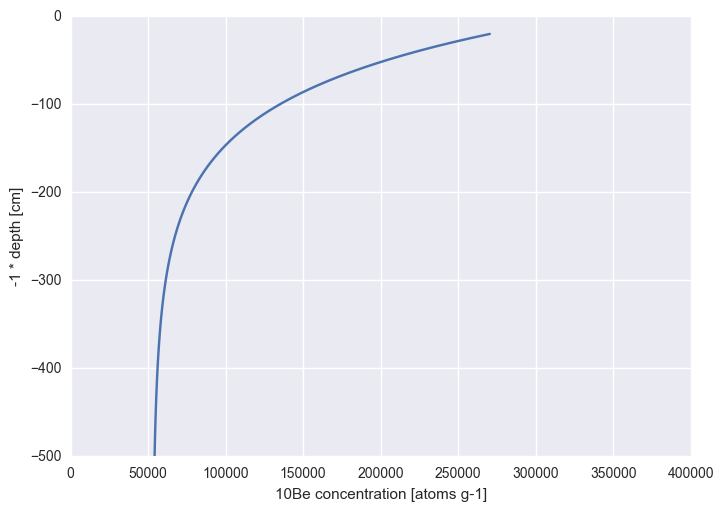

In [4]:
we = widgets.FloatSliderWidget(min=0., max=3e-3, step=5e-4, value=1e-3,
                               description="erosion rate [cm yr-1]")
wt = widgets.FloatSliderWidget(min=0., max=3e5, step=5e4, value=1e5,
                               description="exposure time [yr]")
wd = widgets.FloatSliderWidget(min=1.8, max=2.3, step=0.1, value=2.,
                               description="soil density [g cm-3]")
wi = widgets.FloatSliderWidget(min=0., max=1e5, step=2.5e4, value=0.5e5,
                               description="inheritance [atoms g-1]")

w = widgets.interact(plot_profile_model,
                     erosion_rate=we,
                     exposure_time=wt,
                     soil_density=wd,
                     inheritance=wi)